In [240]:
using DataFrames
using ControlSystemsBase
using Statistics
using Distributions
using Plots
using JLD
using GLM

using RealTimeScheduling
using ControlTimingSafety

push!(LOAD_PATH, "../lib")
using Experiments
using Benchmarks

## SHT

Address the issue about equal prior belief for $H_0$ and $H_1$. Recall that given deviation upper bound $d_{ub}$, confidence level $c$, and the set of all possible samples $X$, the two hypothesis are defined as follows:
$$
\DeclareMathOperator{\dev}{Deviation}
H_0: Pr(\dev(x) < d_{ub} | x \in X) < c \\
H_1: Pr(\dev(x) < d_{ub} | x \in X) > c
$$
assuming that the sample $x$ is drawn uniformly from the set $X$.



In the paper, the Bayes Factor $B$ is used to compute $K$, the number of required samples to draw to give 
\begin{align}
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{Pr(H_1|Data)}{Pr(H_0|Data)} \\
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{\frac{Pr(Data|H_1)Pr(H_1)}{Pr(Data)}}{\frac{Pr(Data|H_0)Pr(H_0)}{Pr(Data)}} \\
B &= \frac{Pr(Data|H_1)}{Pr(Data|H_0)} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) f_{\theta|H_1}(q)dq}
          {\int_0^c P(Data|\theta=q, H_0) f_{\theta|H_0}(q)dq} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) \frac{1}{1-c} dq}
          {\int_0^c P(Data|\theta=q, H_0) \frac{1}{c} dq} \\
B &= \frac{c \int_c^1 q^K dq}
          {(1-c) \int_0^c q^K dq} \\
\frac{1-c}{c} B &= \frac{\int_c^1 q^K dq}
                        {\int_0^c q^K dq} \\
K &= -\log_c(\frac{1-c}{c}B + 1)
\end{align}

<!-- Traditionally, a Bayes factor $B$ of $100$ is considered extreme evidence favoring the alternative hypothesis. However, the paper we are based on states the type-I error is expressed by
$$
err = \frac{c}{c(1-c)B}
$$
Which is ~$.497$ when $B=100$, and ~$.000238$ when $B=4.15e5$. -->

In [25]:
let
    c = 0.99
    B = 100
    e = c/(c+(1-c)*B)
    B_og = 4.15e5
    e_og = c/(c+(1-c)*B_og)
    [e e_og]
end

1×2 Matrix{Float64}:
 0.497487  0.000238497

In [38]:
let
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-10, 1-1e-15, 1-1e-16]
    [-log.(c, c./ (1 .- c)) -log.(c, 4.15e5+1)]
end

7×2 Matrix{Float64}:
    20.8543        122.779
   457.211        1287.12
  6903.3         12929.6
 92097.8             1.29354e5
     2.30258e11      1.2936e11
     3.45672e16      1.29464e16
     3.30896e17      1.16517e17

In [20]:
let
    B = 4.15e5
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-10, 1-1e-15, 1-1e-16]
    # effective_B = c ./ (1 .- c) * B
    effective_B = (1 .- c) ./ c * B
    K = -log.(c, effective_B .+ 1)
    K_og = -log.(c, B+1)

    round.([c K_og K K_og./K], sigdigits=4)
end

7×4 Matrix{Float64}:
 0.9        122.8          101.9       1.205
 0.99      1287.0          829.9       1.551
 0.999    12930.0         6029.0       2.145
 0.9999  129400.0        37490.0       3.45
 1.0          1.294e11  415000.0  311700.0
 1.0          1.295e16  415000.0       3.12e10
 1.0          1.165e17  415000.0       2.808e11

In [43]:
let
    B = 100
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-10, 1-1e-15, 1-1e-16]
    # effective_B = c ./ (1 .- c) * B
    effective_B = (1 .- c) ./ c * B
    K = -log.(c, effective_B .+ 1)
    K_og = -log.(c, B+1)

    round.([c K_og K], sigdigits=4)
end

7×3 Matrix{Float64}:
 0.9        43.8        23.67
 0.99      459.2        69.47
 0.999    4613.0        95.35
 0.9999  46150.0        99.51
 1.0         4.615e10  100.0
 1.0         4.619e15  100.0
 1.0         4.157e16  100.0

## Experiments

### pWCET Sampler

In [2]:
sp = SamplerPWCET(0.9, 100)

SamplerPWCET(0.9, 100)

In [3]:
mean([sum(rand(sp)) for i in 1:100])

89.86

### System Dynamics

Open-loop stable system:
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} -6.0 & 1.0 \\ 0.2 & -0.7 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 5.0 \\ 0.5 \end{bmatrix} u(t)
$$
where
$$
\mathbf{x}(t) = \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix}
$$
is the system state and $u(t)$ is the control input.

We also have a open-loop unstable system:
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} 0 & 6.5 \\ 0 & 0 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 0 \\ 19.685 \end{bmatrix} u(t)
$$

In [4]:
benchmarks[:RCN], benchmarks[:F1T]

(StateSpace{Continuous, Float64}
A = 
 -6.0   1.0
  0.2  -0.7
B = 
 5.0
 0.5
C = 
 1.0  0.0
 0.0  1.0
D = 
 0.0
 0.0

Continuous-time state-space model, StateSpace{Continuous, Float64}
A = 
 0.0  6.5
 0.0  0.0
B = 
  0.0
 19.68503937007874
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model)

In [5]:
# Setting parameters for the experiment
H = 100
c = 0.99
B = 4.15e5
h = 0.02
sys = benchmarks[:F1T]
x0 = 1.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u0]

# Construct an automaton with no constraint
a = hold_kill(c2d(sys, h), delay_lqr(sys, h))

Automaton(AbstractMatrix{Float64}[[1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; -0.582977923541146 -0.9271753376618662 -0.3501109341069651], [1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; 0.0 0.0 1.0]], Union{Missing, Int64}[1 1], Union{Missing, Int64}[1 2], 1, [1.0 0.0 0.0])

### Simulations

In [ ]:
n = 100000
res99 = sim(a, z0, 0.99, n)
res90 = sim(a, z0, 0.90, n)
res50 = sim(a, z0, 0.50, n)

In [118]:
res10 = sim(a, z0, 0.10, n)

100000-element Vector{Tuple{BitVector, Float64}}:
 ([1, 0, 1, 1, 0, 1, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.08397684914638875)
 ([1, 0, 1, 1, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 0.10536880049231159)
 ([1, 0, 1, 0, 0, 1, 0, 1, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.12805494567848735)
 ([1, 1, 0, 0, 1, 1, 0, 0, 1, 0  …  0, 1, 1, 0, 0, 0, 0, 0, 1, 0], 0.12935601915023684)
 ([0, 1, 0, 0, 1, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 1, 1, 0, 0  …  0, 0, 0, 1, 0, 1, 0, 0, 1, 0], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 0, 0, 0, 1  …  0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 0, 0, 0, 1  …  0, 0, 0, 1, 0, 0, 0, 0, 1, 1], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 0, 1, 0, 1  …  1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 1, 0, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.13042136440054303)
 ([0, 1, 0, 0, 1, 0, 0, 1, 0, 0  …  1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.1

In [73]:
save("../data/res99.jld", "res99", res99)
save("../data/res99.jld", "res90", res90)
save("../data/res50.jld", "res50", res50)

In [120]:
save("../data/res50.jld", "res10", res10)

In [86]:
devs99 = map(x -> x[2], res99)
sigm99 = map(x -> x[1], res99);

In [83]:
map(filter(x -> misstotal(x[1]) < 3, res99)) do x
    (missfirst(x[1]), x[2])
end

92055-element Vector{Tuple{Any, Float64}}:
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 (nothing, 0.0)
 ⋮
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.1786396896500381)
 (1, 0.36408893924524055)
 (1, 0.36408893924524055)

In [108]:
map(collect(filter(x -> misstotal(x[1]) < 3, res99))[end-3:end]) do x
    println(x[1], x[2])
end

Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]0.1786396896500381
Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]0.1786396896500381
Bool[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]0.36408893924524055
Bool[0, 0, 1, 1, 1, 1, 1, 1, 1

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

100000


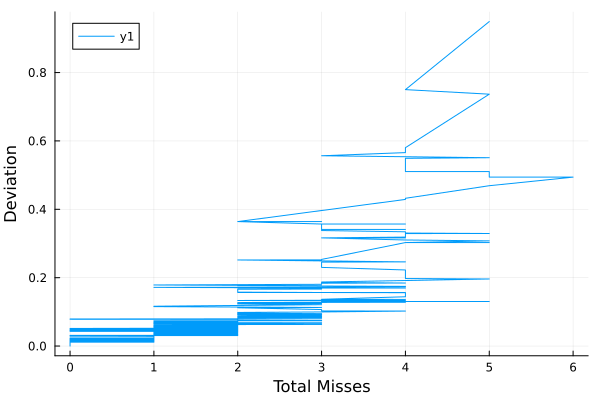

In [285]:
res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs3 = map(x -> x[1:3], σs)
σs5 = map(x -> x[1:5], σs)
σs7 = map(x -> x[1:7], σs)
σsx = map(x -> x[1:10], σs)
σx = σs7
p1 = plot(devs, (1:length(res)) ./ length(res), 
    xlabel="Deviation", ylabel="Probability", label="cdf", title="p=0.10")
p2 = plot(missrow.(σx), devs,
    ylabel="Deviation", xlabel="Consecutive Misses", label="p=0.9")
p3 = plot(misstotal.(σx), devs,
    ylabel="Deviation", xlabel="Total Misses")
p4 = plot(missfirst.(σs), devs,
    ylabel="Deviation", xlabel="First Miss")
for c in [0.99]
    dev = devs[round(Int64, length(res)*c)]
    scatter!(p1, [dev], [c], label="99th quantile = $(round(dev, sigdigits=3))")
end
println(length(res))
savefig(p2, "cv_cm_7.pdf")
savefig(p3, "cv_tm_7.pdf")
display(p3)

In [126]:
for res in [res99, res90, res50, res10]
    devs = map(x -> x[2], res)
    dev = devs[round(Int64, length(res)*0.99)]
    println(round.([dev, devs[end], dev/devs[end]], sigdigits=3))
end

[0.157, 0.364, 0.43]
[0.316, 0.949, 0.333]
[1.66, 8.4, 0.197]
[36200.0, 181000.0, 0.2]


### Deviation Estimation

In [121]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind = Inf
    maxd = 0.
    sample_t = 0
    devest_t = 0
    for i in 1:50
        t = time()
        sp = SamplerPWCET(p, 100)
        sample_t += time() - t

        t = time()
        dub = estimate_deviation(a, sp, z0, c, B)
        devest_t += time() - t

        mind = min(mind, dub)
        maxd = max(maxd, dub)
    end
    @info p sample_t devest_t mind maxd
end

┌ Info: 0.1
│   sample_t = 9.5367431640625e-7
│   devest_t = 23.345851182937622
│   mind = 55793.09195620366
└   maxd = 169259.09273719584
┌ Info: 0.5
│   sample_t = 3.0994415283203125e-6
│   devest_t = 20.82330822944641
│   mind = 2.813927962878087
└   maxd = 10.183354524812206
┌ Info: 0.9
│   sample_t = 9.5367431640625e-7
│   devest_t = 16.726104497909546
│   mind = 0.36408893924524055
└   maxd = 0.7500325054989697
┌ Info: 0.99
│   sample_t = 2.86102294921875e-6
│   devest_t = 12.922874212265015
│   mind = 0.1786396896500381
└   maxd = 0.36408893924524055


In [146]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind = Inf
    maxd = 0.
    sample_t = 0
    devest_t = 0
    for i in 1:50
        t = time()
        sp = SamplerPWCET(p, 100)
        sample_t += time() - t

        t = time()
        dub = estimate_deviation(a, sp, z0, c, B)
        devest_t += time() - t

        mind = min(mind, dub)
        maxd = max(maxd, dub)
    end
    @info p sample_t devest_t mind maxd maxd/mind
end

┌ Info: 0.1
│   sample_t = 9.5367431640625e-7
│   devest_t = 13.22690224647522
│   mind = 56894.61893601
│   maxd = 195505.8547840998
└   maxd / mind = 3.4362802395071377
┌ Info: 0.5
│   sample_t = 0.0
│   devest_t = 12.507431507110596
│   mind = 2.2659246255384677
│   maxd = 12.082469778472145
└   maxd / mind = 5.332246996345212
┌ Info: 0.9
│   sample_t = 1.9073486328125e-6
│   devest_t = 10.985266923904419
│   mind = 0.36408893924524055
│   maxd = 0.9491345984884901
└   maxd / mind = 2.606875672894799
┌ Info: 0.99
│   sample_t = 3.0994415283203125e-6
│   devest_t = 9.798934698104858
│   mind = 0.1786396896500381
│   maxd = 0.36408893924524055
└   maxd / mind = 2.0381189642598714


In [ ]:
mind = Inf
maxd = 0.
x0 = 1.
u0 = 0.
for i in 1:50
    sp = SamplerPWCET(0.4, 100)
    # Construct an automaton with no constraint
    a = hold_kill(c2d(sys, h), delay_lqr(sys, h))
    dub = estimate_deviation(a, sp, [fill(x0, size(sys.A, 1)); u0], c, B)
    mind = min(mind, dub)
    maxd = max(maxd, dub)
end
mind, maxd

(7.682988956551734, 47.57667559506544)

In [5]:
mind = Inf
maxd = 0.
sys = benchmarks[:F1T]
x0 = 1.
u0 = 0.
for i in 1:50
    sp = SamplerPWCET(0.9, 100)
    # Construct an automaton with no constraint
    a = hold_kill(c2d(sys, h), delay_lqr(sys, h))
    dub = estimate_deviation(a, sp, [fill(x0, size(sys.A, 1)); u0], c, B)
    mind = min(mind, dub)
    maxd = max(maxd, dub)
end
mind, maxd

(0.36408893924524055, 0.7500325054989697)

In [8]:
mind = Inf
maxd = 0.
sys = benchmarks[:F1T]
x0 = 1.
u0 = 0.
for i in 1:50
    sp = SamplerPWCET(0.99, 100)
    # Construct an automaton with no constraint
    a = hold_kill(c2d(sys, h), delay_lqr(sys, h))
    dub = estimate_deviation(a, sp, [fill(x0, size(sys.A, 1)); u0], c, B)
    mind = min(mind, dub)
    maxd = max(maxd, dub)
end
mind, maxd

(0.1786396896500381, 0.556620683191605)

### Likelihood Ratio Test

\begin{align}
\lambda_{LR} &=\frac{\sup_{\theta_0\in\Theta_0}{L}(\theta_0)}{\sup_{\theta\in\Theta}L(\theta)} \\
&= \frac{\binom{n}{x} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{x} \theta^x (1-\theta)^{n-x}} \\
&= \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta^x (1-\theta)^{n-x}} \\
&= \left(\frac{\theta_0}{\theta}\right)^x + \left(\frac{1-\theta_0}{1-\theta}\right)^{n-x}
\end{align}

\begin{align}
&= -2 \ln \left[ \frac{\binom{n}{k} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{k} \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 \ln \left[ \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 (x \ln \frac{\theta_0}{\theta_1} + (n-x) \ln \frac{1-\theta_0}{1-\theta_1})
\end{align}

In [138]:
lr_test(0.99, 100, 99)

1.0

In [215]:
lr_test(0.99, 830, 830)

0.0002383480021365628

In [221]:
lr_test_2(0.99, 8782, 0.005)

0.00023886693883315912

In [236]:
lr_test_2(0.99, 46500, 0.002)

0.00024492899776616477

Likelihood ratio with null hypothesis: true $\theta$ is within a range (e.g., $[0.899, 0.991]$) instead of $\theta>0.99$ vs $\theta<0.99$.

In [127]:
err = 0.000238497

0.000238497

In [181]:
n = 8782
for p in [0.99, 0.90, 0.50, 0.10]
    mind = Inf
    maxd = 0.
    devest_t = 0
    for i in 1:50
        t = time()
        lrres = sim(σ p, n)
        x = round(Int64, n * 0.99)
        dev = lrres[x][2]
        devest_t += time() - t
        
        mind = min(mind, dev)
        maxd = max(maxd, dev)
    end
    @info p devest_t mind maxd maxd/mind
end

┌ Info: 0.99
│   devest_t = 268.29211950302124
│   mind = 0.05357866530061128
│   maxd = 0.1786396896500381
└   maxd / mind = 3.334157143477779
┌ Info: 0.9
│   devest_t = 270.07230019569397
│   mind = 0.1786396896500381
│   maxd = 0.36408893924524055
└   maxd / mind = 2.0381189642598714
┌ Info: 0.5
│   devest_t = 270.786817073822
│   mind = 1.53764165422606
│   maxd = 1.700396588522794
└   maxd / mind = 1.1058471158409489
┌ Info: 0.1
│   devest_t = 267.83709025382996
│   mind = 33084.817853965316
│   maxd = 41027.48633521489
└   maxd / mind = 1.2400698869284426


### Control Variate

In [291]:
# Using values from simulation

res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs5 = map(x -> x[1:7], σs)

X = devs
Y = missrow.(σs)
Y5 = missrow.(σs5)
Z = misstotal.(σs)
Z5 = misstotal.(σs5)
U = missfirst.(σs)

data = DataFrame(Dev=X, CM=Y, TM=Z, FM=U, CM5=Y5, TM5=Z5)

ols_y = lm(@formula(Dev ~ CM5), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Dev ~ 1 + CM5

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.00110536  0.000205745   -5.37    <1e-07  -0.00150862  -0.000702101
CM5           0.0682642   0.00024464   279.04    <1e-99   0.0677847    0.0687437
──────────────────────────────────────────────────────────────────────────────────

In [292]:
ols_z = lm(@formula(Dev ~ TM5), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Dev ~ 1 + TM5

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  0.00116479  0.000195524    5.96    <1e-08  0.000781561  0.00154801
TM5          0.0533989   0.000184903  288.79    <1e-99  0.0530365    0.0537613
───────────────────────────────────────────────────────────────────────────────

In [290]:
ols_u = lm(@formula(Dev ~ FM), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Dev ~ 1 + FM

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.0707225  0.000252406   280.19    <1e-99   0.0702278    0.0712172
FM           -0.0032327  1.83743e-5   -175.94    <1e-99  -0.00326871  -0.00319668
─────────────────────────────────────────────────────────────────────────────────